In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import numpy as np

#데이터 준비하기

In [ ]:
train = pd.read_csv("./ua.base", sep="\t", names=['user','movie','rating','timestamp'])
test = pd.read_csv("./ua.test", sep="\t", names=['user','movie','rating','timestamp'])

items_train = torch.LongTensor(train['movie'])
users_train = torch.LongTensor(train['user'])
ratings_train = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

item = pd.read_csv("./u.item", sep="\|",usecols=[0,1], names=['id', 'title'], encoding = 'ISO-8859-1')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':


#Latent Factor 모델을 이용하여 학습하기



In [ ]:
rank = 100
numItems = items_train.max() + 1
numUsers = users_train.max() + 1

# Task 2-1.
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = ratings_train.sum() / len(ratings_train)

optimizer = torch.optim.Adam([P,Q,bias_user,bias_item], lr=0.1)

lambda1 = 0.00001
lambda2 = 0.00001
lambda3 = 0.0001 #bias_item
lambda4 = 0.0001 #bias_user

X = []
Y = []
Y_test = []
for epoch in range(1001):
  hypothesis = torch.sum(P[items_train] * Q[users_train], dim=1) + mean + bias_item[items_train] + bias_user[users_train]
  # mse = torch.mean((hypothesis-ratings) ** 2)
  mse = F.mse_loss(hypothesis, ratings_train)
  
  # 정규화항 추가한 cost
  # Task 2-2.
  cost = mse + lambda1* (P ** 2).sum() + lambda2 * (Q ** 2).sum() + \
  lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  # Task 2-3.
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + \
    bias_item[items_test] + bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)

    X.append(epoch)
    Y.append(mse.item()**0.5)
    Y_test.append(mse_test.item()**0.5)

  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost: {mse.item():.6f}")

epoch: 0, cost: 103.781044
epoch: 100, cost: 0.064412
epoch: 200, cost: 0.020451
epoch: 300, cost: 0.011644
epoch: 400, cost: 0.008808
epoch: 500, cost: 0.007602
epoch: 600, cost: 0.006968
epoch: 700, cost: 0.006573
epoch: 800, cost: 0.006293
epoch: 900, cost: 0.006087
epoch: 1000, cost: 0.005927


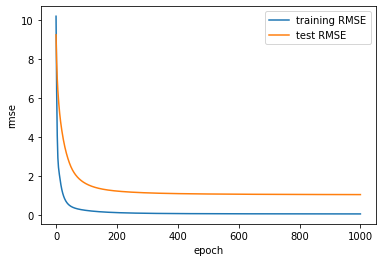

In [ ]:
plt.xlabel("epoch")
plt.ylabel("rmse")
plt.plot(X, Y, label="training RMSE")
plt.plot(X, Y_test, label="test RMSE")
plt.legend()
plt.show()

# 13번 User에게 추천하기 (knn search)

> 13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기

> Latent Matrix P와 Q를 이용하여 13번 user와 cosine similarity가 가장 유사한 영화 top 20개를 찾아서 id 및 영화이름 출력하기

In [ ]:
P.requires_grad_(False)
Q.requires_grad_(False)
bias_user.requires_grad_(False)
bias_item.requires_grad_(False)

# P = P.numpy()
# Q = Q.numpy()

# 13번 user의 전체영화에 대한 예상 평점
user_13_rating = torch.sum(P[1:] * Q[13], dim=1) + mean + bias_item[1:] + bias_user[13]

# 13번 user의 top20개 영화 인덱스
top_20 = sorted(range(len(user_13_rating)),key= lambda i: user_13_rating[i], reverse=True)[:20]

top_20_r_vector = [ P[i+1].numpy() for i in top_20 ]
item.iloc[top_20]

,id,title
97,98,"Silence of the Lambs, The (1991)"
659,660,Fried Green Tomatoes (1991)
168,169,"Wrong Trousers, The (1993)"
213,214,Pink Floyd - The Wall (1982)
962,963,Some Folks Call It a Sling Blade (1993)
214,215,Field of Dreams (1989)
1141,1142,When We Were Kings (1996)
512,513,"Third Man, The (1949)"
245,246,Chasing Amy (1997)
527,528,"Killing Fields, The (1984)"


In [ ]:
def get_cosine_similarity(x1, x2):
  return (x1 * x2).sum() / (((x1**2).sum()**.5) * ((x2**2).sum()**.5))

cosinsimilarity = [ get_cosine_similarity(Q[13], item) for item in P[1:] ]
top_20_movie = sorted(range(len(cosinsimilarity)),key= lambda i: cosinsimilarity[i], reverse=True)[:20]

top_20_c_vector = [ P[i+1].numpy() for i in top_20_movie ]
item.iloc[top_20_movie]

,id,title
813,814,"Great Day in Harlem, A (1994)"
850,851,Two or Three Things I Know About Her (1966)
866,867,"Whole Wide World, The (1996)"
847,848,"Murder, My Sweet (1944)"
810,811,Thirty-Two Short Films About Glenn Gould (1993)
867,868,Hearts and Minds (1996)
97,98,"Silence of the Lambs, The (1991)"
790,791,"Baby-Sitters Club, The (1995)"
914,915,Primary Colors (1998)
792,793,Crooklyn (1994)


# 영화 클러스터링하기 (k-means clustering)


In [ ]:
def kmeans(k, P):
  # 1. 임의로 k개의 점을 중심점으로 선택 (forgy)
  centroids = random.choices(P, k = k)
  prev_assignments = []
  clusters = [[] for _ in range(k)]

  for epoch in range(10):
    # 2. 각 점이 할당될 중심점을 계산
    assignments = []
    for p in P:
      min_c_idx = -1
      min_c_dist = 9**9
      for i, c in enumerate(centroids):
        cosine_distance = - get_cosine_similarity(p, c)
        if(min_c_dist > cosine_distance):
          min_c_dist = cosine_distance
          min_c_idx = i
      assignments.append(min_c_idx)
      
    # 3. 새로운 centroid 계산
    
    for a, b in zip(assignments, P):
      clusters[a].append(b)
    
    centroids = [np.mean(c, axis = 0 ) for c in clusters] 
    
    # 4. 클러스터에 변화가 없을 경우 종료
    if(prev_assignments == assignments):
      break
    prev_assignments = assignments
    
  return prev_assignments, centroids, clusters

In [ ]:

x = []
y = []

for i in range(1, 41):
  cost = 0
  assignments, centroids, clusters = kmeans(i, P.numpy())
  for a, p in zip(assignments, P.numpy()):
    cost += (1 -get_cosine_similarity(centroids[a], p))
  x.append(i)
  y.append(cost)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


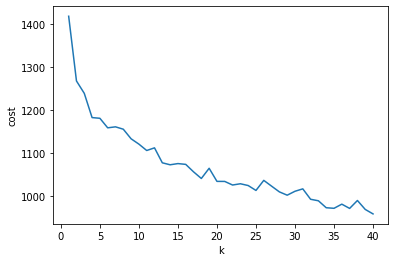

In [ ]:
plt.xlabel("k")
plt.ylabel("cost")
plt.plot(x, y)
plt.show()

In [ ]:

k = 4
assignments, centroids, clusters = kmeans(k, P.numpy())

# 차원 축소 및 시각화 (PCA)

> P 행렬와 Q 행렬을 합쳐 Z행렬 만들기

> Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기

>  P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


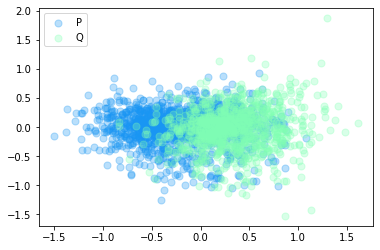

In [ ]:
# Task 5-1

from sklearn import decomposition

Z = torch.cat((P, Q), dim = 0)

# Task 5-2

Z = torch.FloatTensor(Z.detach().numpy())
pca = decomposition.PCA(100)
pca.fit(Z)
T = pca.transform(Z[:len(P)-1])
R = pca.transform(Z[len(P):])

# Task 5-3-1

plt.scatter(T[:,0], T[:,1], s= 50, c=plt.cm.rainbow(0.2), label = 'P', alpha=0.3)
plt.scatter(R[:,0], R[:,1], s= 50, c=plt.cm.rainbow(0.5), label = 'Q', alpha=0.3)

plt.legend(fontsize= 10)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

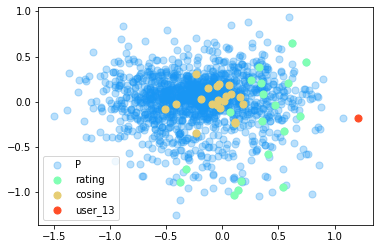

In [ ]:
# Task 5-3-2

P_ = T

T = pca.transform(top_20_r_vector)
R = pca.transform(top_20_c_vector)
U = pca.transform(Q[13].view(1,-1).detach().numpy())

# P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기
plt.scatter(P_[:,0], P_[:,1], s= 50, c=plt.cm.rainbow(0.2), label = 'P', alpha=0.3)
plt.scatter(T[:,0], T[:,1], s= 50, c=plt.cm.rainbow(0.5), label = 'rating')
plt.scatter(R[:,0], R[:,1], s= 50, c=plt.cm.rainbow(0.7), label = 'cosine')
plt.scatter(U[:,0], U[:,1], s= 50, c=plt.cm.rainbow(0.9), label = 'user_13')

plt.legend(fontsize= 10)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

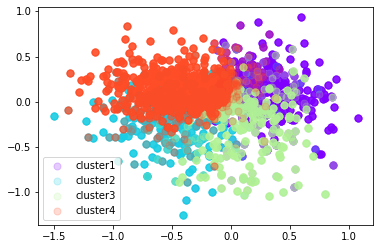

In [ ]:
# Task 5-3-3

labels = ['cluster1', 'cluster2','cluster3','cluster4','cluster5']
for i, c in enumerate(clusters):
  Z = pca.transform(c)
  plt.scatter(Z[:,0], Z[:,1], s= 50, c=plt.cm.rainbow(i*0.3), label = labels[i], alpha=0.2)

plt.legend(fontsize= 10)
plt.show()